In [95]:
import time
import warnings
import datetime
import numpy as np
import pandas as pd
import xgboost as xgb
from xgboost import XGBRegressor
from collections import deque
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, accuracy_score
from pandas.plotting import autocorrelation_plot
from statsmodels.tsa.arima_model import ARIMA

%matplotlib inline
warnings.filterwarnings('ignore')

In [9]:
def parser(x):
    return datetime.datetime.strptime(x,'%m/%d/%Y')

In [10]:
tesla_df = pd.read_csv("tesla.csv", header=0, parse_dates=[0], date_parser=parser)
tesla_df[['Date', 'Close']].head(3)

,Date,Close
0,2010-06-29,23.889999
1,2010-06-30,23.830000
2,2010-07-01,21.959999


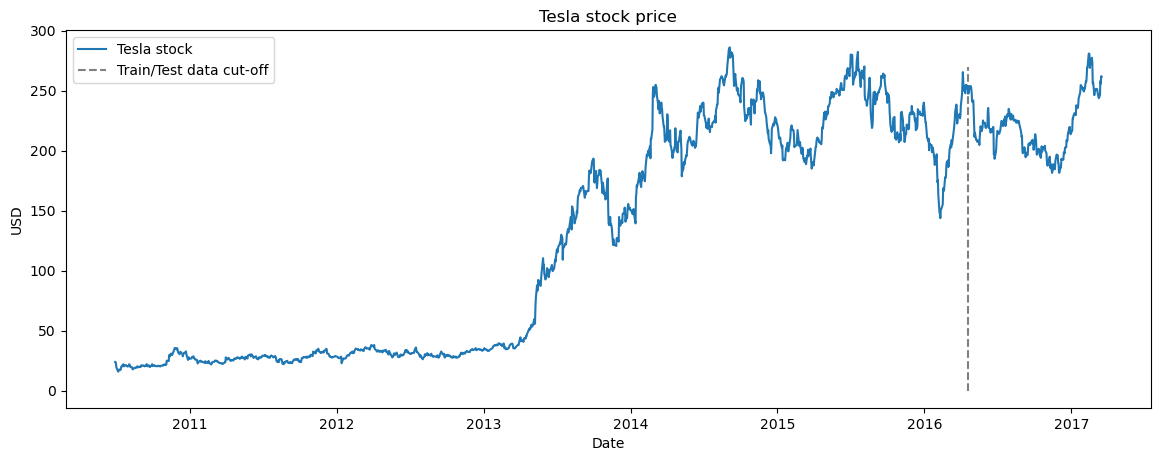

In [11]:
plt.figure(figsize=(14, 5), dpi=100)
plt.plot(tesla_df['Date'], tesla_df['Close'], label='Tesla stock')
plt.vlines(datetime.date(2016,4,20), 0, 270, linestyles='--', colors='gray', label='Train/Test data cut-off')
plt.xlabel('Date')
plt.ylabel('USD')
plt.title('Tesla stock price')
plt.legend()
plt.show()


In [12]:
def getTechnicalIndicators(dataset):
    
    # Create 7 and 21 Moving Average
    dataset['7ma'] = dataset['Close'].rolling(window=7).mean()
    dataset['21ma'] = dataset['Close'].rolling(window=21).mean()
    
    # Create MACD 
    dataset['26ema'] = dataset['Close'].ewm(span=26).mean()
    dataset['12ema'] = dataset['Close'].ewm(span=12).mean()
    dataset["MACD"] = (dataset['12ema'] - dataset['26ema'])
    
    # Create Bollinger Bands
    dataset['20sd'] = dataset['Close'].rolling(window=20).mean()
    dataset['Upper Band'] = (dataset['Close'].rolling(window=20).mean()) + (dataset['20sd']*2)
    dataset['Lower Band'] = (dataset['Close'].rolling(window=20).mean()) - (dataset['20sd']*2)
    
    # Create Expotential Moving Average
    dataset['ema'] = dataset['Close'].ewm(com=0.5).mean()
    
    #Create Momentum
    dataset['momentum'] = (dataset['Close']/100)-1
    
    return dataset

In [13]:
featured_tesla = getTechnicalIndicators(tesla_df)
featured_tesla.head()

,Date,Open,High,Low,Close,Volume,Adj Close,7ma,21ma,26ema,12ema,MACD,20sd,Upper Band,Lower Band,ema,momentum
0,2010-06-29,19.000000,25.00,17.540001,23.889999,18766300,23.889999,NaN,NaN,23.889999,23.889999,0.000000,NaN,NaN,NaN,23.889999,-0.7611
1,2010-06-30,25.790001,30.42,23.299999,23.830000,17187100,23.830000,NaN,NaN,23.858846,23.857500,-0.001346,NaN,NaN,NaN,23.845000,-0.7617
2,2010-07-01,25.000000,25.92,20.270000,21.959999,8218800,21.959999,NaN,NaN,23.176608,23.116905,-0.059704,NaN,NaN,NaN,22.539999,-0.7804
3,2010-07-02,23.000000,23.10,18.709999,19.200001,5139800,19.200001,NaN,NaN,22.064923,21.880491,-0.184432,NaN,NaN,NaN,20.285500,-0.8080
4,2010-07-06,20.000000,20.00,15.830000,16.110001,6866900,16.110001,NaN,NaN,20.683952,20.312670,-0.371282,NaN,NaN,NaN,17.490331,-0.8389


In [15]:
featured = featured_tesla[-500:]
featured.head()

,Date,Open,High,Low,Close,Volume,Adj Close,7ma,21ma,26ema,12ema,MACD,20sd,Upper Band,Lower Band,ema,momentum
1192,2015-03-25,198.270004,198.589996,192.699997,194.300003,5730400,194.300003,197.831430,197.301906,199.321411,197.221642,-2.099769,196.979002,590.937005,-196.979002,196.465852,0.9430
1193,2015-03-26,193.919998,194.789993,189.699997,190.410004,4128000,190.410004,197.214288,196.666192,198.661306,196.173698,-2.487609,196.140002,588.420005,-196.140002,192.428620,0.9041
1194,2015-03-27,189.070007,189.289993,181.399994,185.000000,8604900,185.000000,194.970001,195.609525,197.649358,194.454667,-3.194691,195.223002,585.669006,-195.223002,187.476207,0.8500
1195,2015-03-30,185.850006,192.250000,181.800003,190.570007,10089500,190.570007,194.244289,195.001431,197.124961,193.857027,-3.267934,194.885002,584.655006,-194.885002,189.538740,0.9057
1196,2015-03-31,193.529999,193.759995,188.410004,188.770004,5026600,188.770004,192.914289,194.593812,196.506076,193.074408,-3.431667,194.345502,583.036507,-194.345502,189.026249,0.8877


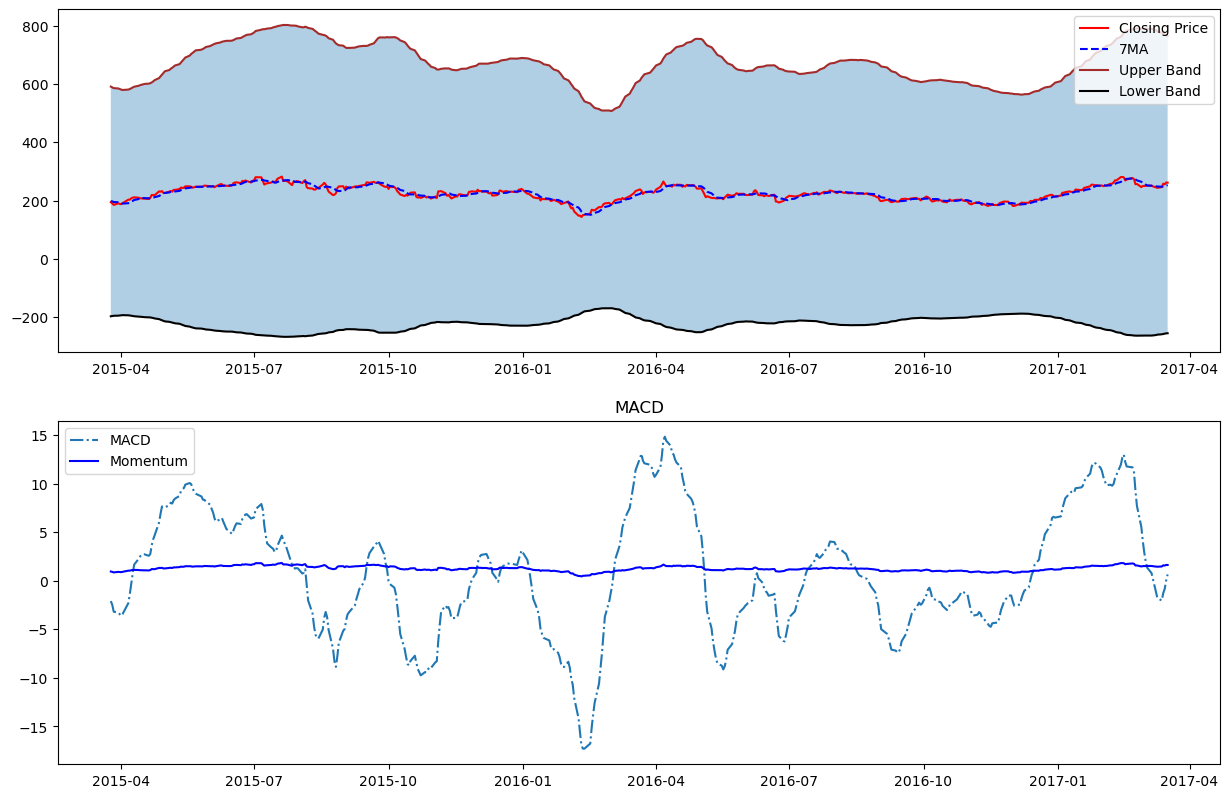

In [16]:
plt.figure(figsize=(15, 10), dpi=100)

plt.subplot(2, 1, 1)
plt.plot(featured['Date'], featured['Close'], label='Closing Price', color='red')
plt.plot(featured['Date'], featured['7ma'], label='7MA', color='blue', linestyle='--')
plt.plot(featured['Date'], featured['Upper Band'], label='Upper Band', color='brown')
plt.plot(featured['Date'], featured['Lower Band'], label='Lower Band', color='black')
plt.fill_between(featured['Date'], featured['Upper Band'], featured['Lower Band'], alpha=0.35)
plt.legend()

plt.subplot(2, 1, 2)
plt.title('MACD')
plt.plot(featured['Date'], featured['MACD'],label='MACD', linestyle='-.')
plt.plot(featured['Date'], featured['momentum'], label='Momentum', color='b',linestyle='-')
plt.legend()
    
plt.show()

In [17]:
featured.head()

,Date,Open,High,Low,Close,Volume,Adj Close,7ma,21ma,26ema,12ema,MACD,20sd,Upper Band,Lower Band,ema,momentum
1192,2015-03-25,198.270004,198.589996,192.699997,194.300003,5730400,194.300003,197.831430,197.301906,199.321411,197.221642,-2.099769,196.979002,590.937005,-196.979002,196.465852,0.9430
1193,2015-03-26,193.919998,194.789993,189.699997,190.410004,4128000,190.410004,197.214288,196.666192,198.661306,196.173698,-2.487609,196.140002,588.420005,-196.140002,192.428620,0.9041
1194,2015-03-27,189.070007,189.289993,181.399994,185.000000,8604900,185.000000,194.970001,195.609525,197.649358,194.454667,-3.194691,195.223002,585.669006,-195.223002,187.476207,0.8500
1195,2015-03-30,185.850006,192.250000,181.800003,190.570007,10089500,190.570007,194.244289,195.001431,197.124961,193.857027,-3.267934,194.885002,584.655006,-194.885002,189.538740,0.9057
1196,2015-03-31,193.529999,193.759995,188.410004,188.770004,5026600,188.770004,192.914289,194.593812,196.506076,193.074408,-3.431667,194.345502,583.036507,-194.345502,189.026249,0.8877


## ANALYSIS OF TIME SERIES USING FOURIER TRANSFORM

In [18]:
data_ft = featured_tesla[['Date', 'Close']]
close_fft = np.fft.fft(np.asarray(data_ft['Close'].tolist()))
fft_df = pd.DataFrame({'fft': close_fft})
fft_df['absolute'] = fft_df['fft'].apply(lambda x: np.abs(x))
fft_df['angle'] = fft_df['fft'].apply(lambda x: np.angle(x))

In [19]:
fft_df.head()

,fft,absolute,angle
0,224069.29010058+0.00000000j,224069.290158,0.000000
1,-12560.223404+102241.389547j,103010.004118,1.693033
2,5039.3805960+5218.3938800j,7254.446324,0.802848
3,-4451.816537+023389.4668560j,23809.364340,1.758881
4,6142.277266+010106.5980150j,11826.702560,1.024698


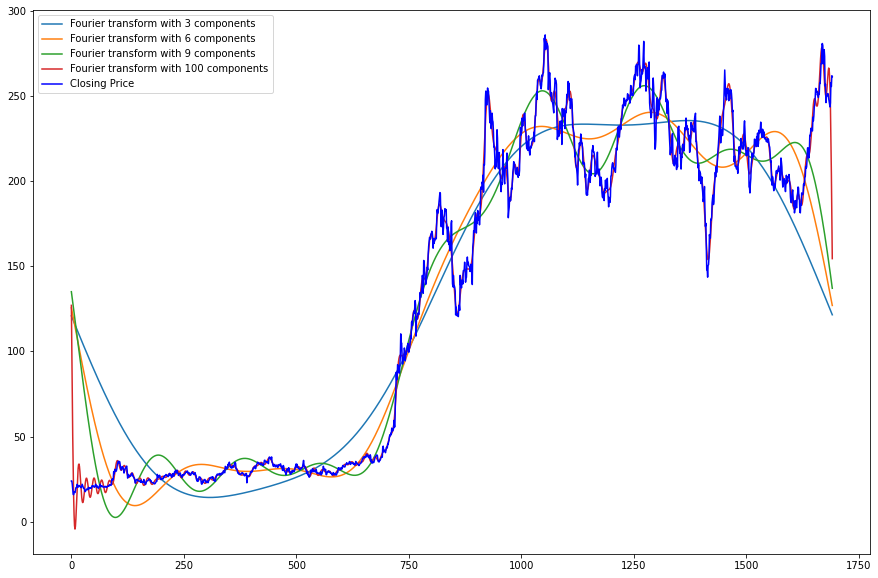

In [20]:
plt.figure(figsize=(15, 10))
fft_list = np.asarray(fft_df['fft'].tolist())
for num_ in [3, 6, 9, 100]:
    fft_list_m10= np.copy(fft_list); 
    fft_list_m10[num_:-num_]=0
    plt.plot(np.fft.ifft(fft_list_m10), label='Fourier transform with {} components'.format(num_))
plt.plot(featured_tesla['Close'], label='Closing Price', color='b')
plt.legend()
plt.show()

In [21]:
featured_tesla['Fourier'] = pd.DataFrame(fft_list_m10).apply(lambda x: np.abs(x))

In [22]:
fft_list = np.asarray(fft_df['fft'].tolist())
fft_list_m10 = np.copy(fft_list)
fft_list_m10[100 : -100] = 0
fft_df['Fourier'] = pd.DataFrame(fft_list_m10).apply(lambda x: np.abs(x))
fft_df.head(30)

,fft,absolute,angle,Fourier
0,224069.29010058+0.00000000j,224069.290158,0.000000,224069.290158
1,-12560.223404+102241.389547j,103010.004118,1.693033,103010.004118
2,5039.3805960+5218.3938800j,7254.446324,0.802848,7254.446324
3,-4451.816537+023389.4668560j,23809.364340,1.758881,23809.364340
4,6142.277266+010106.5980150j,11826.702560,1.024698,11826.702560
5,1091.7332050+9845.1880570j,9905.534275,1.460357,9905.534275
6,-1981.901305+014417.0143260j,14552.602340,1.707410,14552.602340
7,-390.767654-001215.69524400j,1276.955083,-1.881801,1276.955083
8,7123.2322230+8472.8448380j,11069.306073,0.871719,11069.306073
9,4527.8214360+8908.8063550j,9993.397702,1.100578,9993.397702


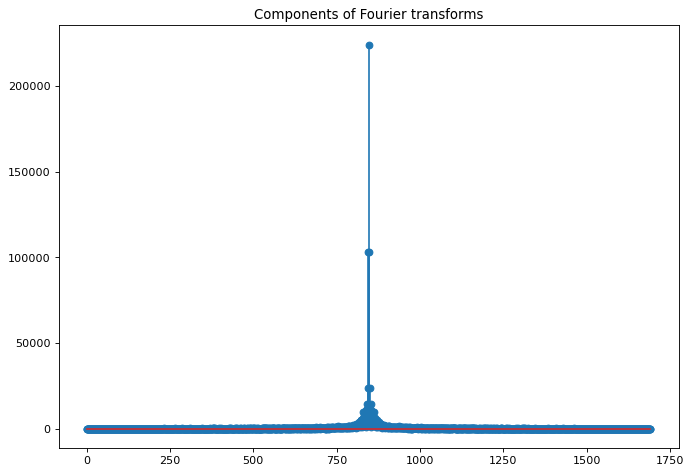

In [23]:
items = deque(np.asarray(fft_df['absolute'].tolist()))
items.rotate(int(np.floor(len(fft_df)/2)))
plt.figure(figsize=(10, 7), dpi=80)
plt.stem(items)
plt.title('Components of Fourier transforms')
plt.show()

## ARIMA

In [24]:
model = ARIMA(featured_tesla['Close'],
              order=(5,1,0))
modelFit = model.fit(disp=0)
print(modelFit.summary())

                             ARIMA Model Results                              
Dep. Variable:                D.Close   No. Observations:                 1691
Model:                 ARIMA(5, 1, 0)   Log Likelihood               -4898.956
Method:                       css-mle   S.D. of innovations              4.385
Date:                Wed, 03 Nov 2021   AIC                           9811.911
Time:                        11:57:25   BIC                           9849.943
Sample:                             1   HQIC                          9825.994
                                                                              
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.1405      0.106      1.329      0.184      -0.067       0.348
ar.L1.D.Close     0.0302      0.024      1.243      0.214      -0.017       0.078
ar.L2.D.Close    -0.0008      0.024     

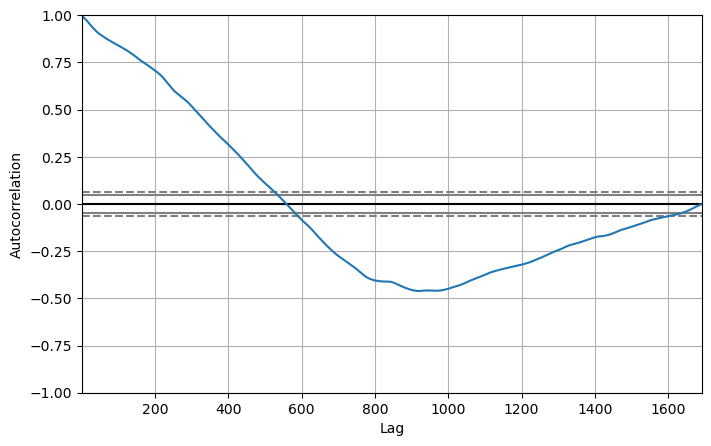

In [25]:
plt.figure(figsize=(8, 5), dpi=100)
autocorrelation_plot(featured_tesla['Close'])
plt.show()

In [27]:
X = featured_tesla['Close'].values
size = int(len(X)*0.7)
X_train, X_test = X[0:size], X[size:len(X)]
history = [x for x in X_train]
predictions = list()
for i in range(len(X_test)):
    model = ARIMA(history, order=(5, 1, 0))
    model_fit = model.fit(disp=0)
    output = model_fit.forecast()
    yhat = output[0]
    predictions.append(yhat)
    obs = X_test[i]
    history.append(obs)
    
featured_tesla['ARIMA'] = pd.DataFrame(predictions) 

In [28]:
featured_tesla.head()

,Date,Open,High,Low,Close,Volume,Adj Close,7ma,21ma,26ema,12ema,MACD,20sd,Upper Band,Lower Band,ema,momentum,Fourier,ARIMA
0,2010-06-29,19.000000,25.00,17.540001,23.889999,18766300,23.889999,NaN,NaN,23.889999,23.889999,0.000000,NaN,NaN,NaN,23.889999,-0.7611,224069.290158,190.834306
1,2010-06-30,25.790001,30.42,23.299999,23.830000,17187100,23.830000,NaN,NaN,23.858846,23.857500,-0.001346,NaN,NaN,NaN,23.845000,-0.7617,103010.004118,188.713381
2,2010-07-01,25.000000,25.92,20.270000,21.959999,8218800,21.959999,NaN,NaN,23.176608,23.116905,-0.059704,NaN,NaN,NaN,22.539999,-0.7804,7254.446324,195.830563
3,2010-07-02,23.000000,23.10,18.709999,19.200001,5139800,19.200001,NaN,NaN,22.064923,21.880491,-0.184432,NaN,NaN,NaN,20.285500,-0.8080,23809.364340,194.932120
4,2010-07-06,20.000000,20.00,15.830000,16.110001,6866900,16.110001,NaN,NaN,20.683952,20.312670,-0.371282,NaN,NaN,NaN,17.490331,-0.8389,11826.702560,200.772214


In [29]:
error = mean_squared_error(X_test, predictions)
print('Test MSE: %.3f' % error)

Test MSE: 28.940


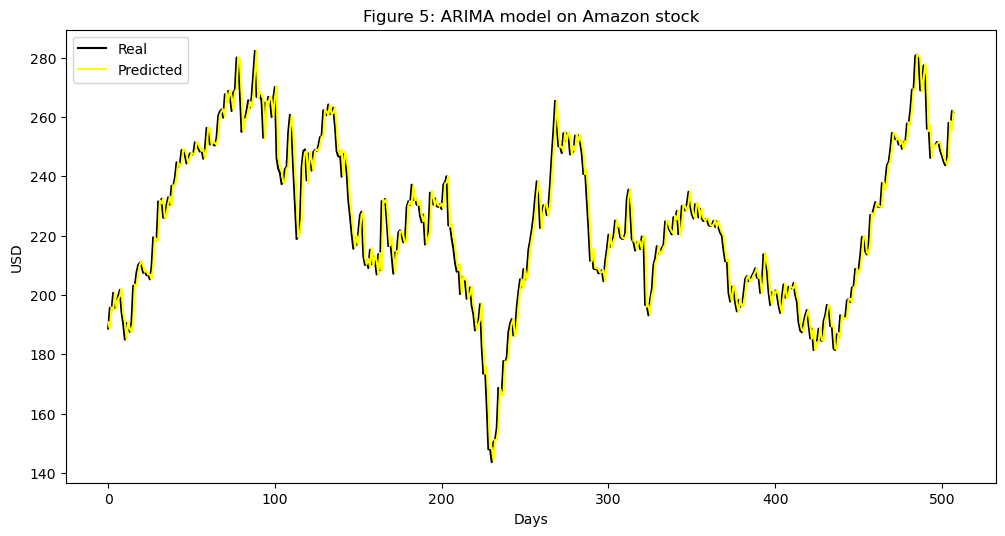

In [30]:
# Plot the predicted (from ARIMA) and real prices
plt.figure(figsize=(12, 6), dpi=100)
plt.plot(X_test, color='black', label='Real')
plt.plot(predictions, color='yellow', label='Predicted')
plt.xlabel('Days')
plt.ylabel('USD')
plt.title('Figure 5: ARIMA model on Amazon stock')
plt.legend()
plt.show()

## XGBoost for Feature Selection

In [31]:
featured_tesla.head()

,Date,Open,High,Low,Close,Volume,Adj Close,7ma,21ma,26ema,12ema,MACD,20sd,Upper Band,Lower Band,ema,momentum,Fourier,ARIMA
0,2010-06-29,19.000000,25.00,17.540001,23.889999,18766300,23.889999,NaN,NaN,23.889999,23.889999,0.000000,NaN,NaN,NaN,23.889999,-0.7611,224069.290158,190.834306
1,2010-06-30,25.790001,30.42,23.299999,23.830000,17187100,23.830000,NaN,NaN,23.858846,23.857500,-0.001346,NaN,NaN,NaN,23.845000,-0.7617,103010.004118,188.713381
2,2010-07-01,25.000000,25.92,20.270000,21.959999,8218800,21.959999,NaN,NaN,23.176608,23.116905,-0.059704,NaN,NaN,NaN,22.539999,-0.7804,7254.446324,195.830563
3,2010-07-02,23.000000,23.10,18.709999,19.200001,5139800,19.200001,NaN,NaN,22.064923,21.880491,-0.184432,NaN,NaN,NaN,20.285500,-0.8080,23809.364340,194.932120
4,2010-07-06,20.000000,20.00,15.830000,16.110001,6866900,16.110001,NaN,NaN,20.683952,20.312670,-0.371282,NaN,NaN,NaN,17.490331,-0.8389,11826.702560,200.772214


In [32]:
featured_tesla.shape

(1692, 19)

In [49]:
def get_feature_importance_data(data_income):
    data = data_income.copy()
    y = data['Close']
    X = data.iloc[:,1:19]
    
    train_samples = int(X.shape[0] * 0.65)
 
    X_train = X.iloc[:train_samples]
    X_test = X.iloc[train_samples:]

    y_train = y.iloc[:train_samples]
    y_test = y.iloc[train_samples:]
    
    return (X_train, y_train), (X_test, y_test)

In [62]:
(X_train_FI, y_train_FI), (X_test_FI, y_test_FI) = get_feature_importance_data(featured_tesla)

In [63]:
regressor = xgb.XGBRegressor(gamma=0.0,n_estimators=200,base_score=0.7,colsample_bytree=1,learning_rate=0.05)

In [65]:
xgbModel = regressor.fit(X_train_FI,y_train_FI, 
                         eval_set = [(X_train_FI, y_train_FI), (X_test_FI, y_test_FI)], 
                         verbose=False)

In [70]:
eval_result = regressor.evals_result()

In [71]:
training = range(len(eval_result['validation_0']['rmse']))

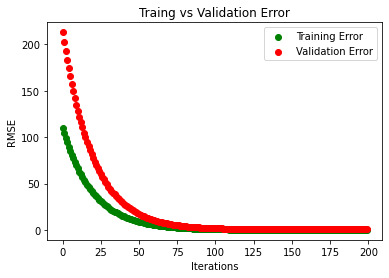

In [78]:
plt.scatter(training, eval_result['validation_0']['rmse'], color='g', label='Training Error');
plt.scatter(training, eval_result['validation_1']['rmse'], color='r', label='Validation Error');
plt.title("Traing vs Validation Error")
plt.xlabel('Iterations')
plt.ylabel('RMSE')
plt.legend();

In [81]:
xgbModel.feature_importances_

array([3.35017107e-02, 4.37406190e-02, 1.23694316e-01, 7.95297205e-01,
       7.28876273e-07, 0.00000000e+00, 6.21680229e-04, 7.27453016e-06,
       5.43302463e-07, 3.94386325e-06, 8.84881842e-07, 5.03036347e-07,
       0.00000000e+00, 0.00000000e+00, 3.13041592e-03, 0.00000000e+00,
       6.37112478e-08, 8.89102481e-08], dtype=float32)

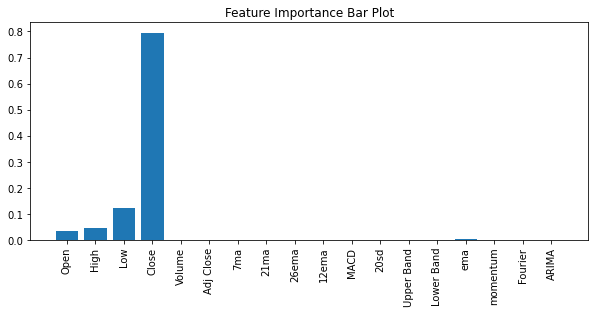

In [88]:
plt.figure(figsize=(10, 4))
plt.bar([x for x in range(len(xgbModel.feature_importances_))],
        xgbModel.feature_importances_,
        tick_label=X_train_FI.columns);
plt.title("Feature Importance Bar Plot");
plt.xticks(rotation='vertical');

In [123]:
model = XGBRegressor()
model.fit(X_train.drop('Date', axis=1), y_train)
y_preds = model.predict(X_test.drop('Date', axis=1))
y_test = [round(value) for value in y_test]
predictions = [round(value) for value in y_preds]

In [124]:
# evaluate predictions
accuracy = accuracy_score(y_test, predictions)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

Accuracy: 40.16%
